## Voting

In [1]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [23]:
lr_clf = LogisticRegression(max_iter=2200)
knn_clf = KNeighborsClassifier(n_neighbors=8)
vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print(f'Voting classifier accuracy: {accuracy_score(y_test, pred)}')

classifiers = [lr_clf, knn_clf]

for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print(f'{class_name} accuracy: {accuracy_score(y_test, pred)}')

Voting classifier accuracy: 0.9473684210526315
LogisticRegression accuracy: 0.9649122807017544
KNeighborsClassifier accuracy: 0.9385964912280702


## Bagging

### 랜덤포레스트 개요 및 실습

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [25]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x: x[0]+'_'+str(x[1])
                                                                                              if x[1] > 0 else x[0], axis=1) 
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)

    return new_feature_name_df

def get_human_dataset():
    feature_name_df = pd.read_csv('./data/human_activity/features.txt', sep='\s+',
                                  header=None, names=['column_index', 'column_name'])
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 칼럼명은 feature_name 적용
    X_train = pd.read_csv('./data/human_activity/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./data/human_activity/test/X_test.txt', sep='\s+', names=feature_name)
    
    y_train = pd.read_csv('./data/human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./data/human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    return X_train, X_test, y_train, y_test

In [26]:
X_train, X_test, y_train, y_test = get_human_dataset()

rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'RandomForest accuracy: {accuracy:.4f}')

RandomForest accuracy: 0.9253


### 랜덤 포레스트 하이퍼 파라미터 및 튜닝

In [27]:
from sklearn.model_selection import GridSearchCV
import time

start = time.time()

params = {
    'n_estimators':[100],
    'max_depth':[6, 8, 10, 12],
    'min_samples_leaf': [8, 12, 18],
    'min_samples_split': [8, 16, 20]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

end = time.time()

sec = end - start

print(sec,'초')
print(grid_cv.best_params_)
print(grid_cv.best_score_)

82.39284062385559 초
{'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
0.9179815016322089


In [28]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8, min_samples_split=8, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print(accuracy_score(y_test, pred))

0.9165252799457075


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

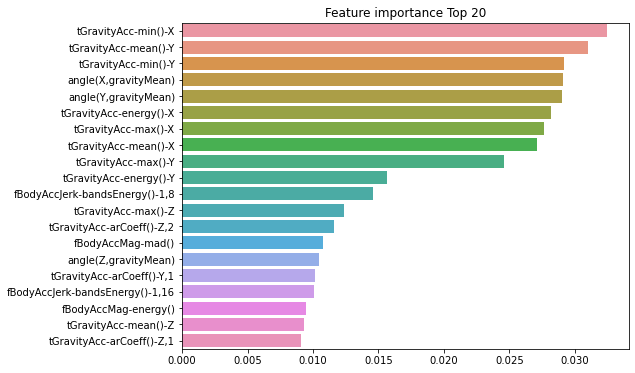

In [31]:
ftr_importance_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importance_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 6))
plt.title('Feature importance Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()